In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LinearRegression as LinReg
import sklearn.neighbors as knn
from sklearn.cross_validation import train_test_split
from scipy import linalg
import matplotlib as mpl
%matplotlib inline

# Food Inspection Data
## First Look

In [2]:
df = pd.read_csv('data/Food_Inspections.csv')
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude,Location
0,1970782,"MARINO'S DISTRIBUTION , INC.",MARINO'S DISTRIBUTION,2495906.0,Grocery Store,Risk 3 (Low),3939 S KEDZIE AVE,CHICAGO,IL,60632.0,11/3/16,License,Pass,41.821458,-87.704350,"(41.82145816352694, -87.70435016027005)"
1,1970772,STARBUCKS COFFEE #2827,STARBUCKS COFFEE #2827,2093906.0,Restaurant,Risk 2 (Medium),1174 E 55TH ST,CHICAGO,IL,60615.0,11/3/16,Canvass,Pass,41.795175,-87.596601,"(41.79517545018063, -87.59660147733702)"
2,1970752,"I 57 FUEL MART, INC","I 57 FUEL MART, INC",2495782.0,Grocery Store,Risk 3 (Low),9901-9909 S HALSTED ST,CHICAGO,IL,60628.0,11/3/16,License,Pass,41.714126,-87.642853,"(41.71412564927746, -87.64285254744291)"
3,1955335,CHIPOTLE MEXICAN GRILL#2768,CHIPOTLE,2476569.0,Restaurant,Risk 1 (High),806 W 63RD ST,CHICAGO,IL,60621.0,11/2/16,License Re-Inspection,Pass,41.779856,-87.645142,"(41.77985559084816, -87.64514243359771)"
4,1955334,CHIPOTLE MEXICAN GRILL#2768,CHIPOTLE,2476568.0,Restaurant,Risk 1 (High),806 W 63RD ST,CHICAGO,IL,60621.0,11/2/16,License Re-Inspection,Pass,41.779856,-87.645142,"(41.77985559084816, -87.64514243359771)"


In [3]:
rest = df[df["Facility Type"] == "Restaurant"]
rest.shape

(87952, 16)

In [4]:
rest.Results.unique()

array(['Pass', 'Pass w/ Conditions', 'Fail', 'No Entry', 'Not Ready',
       'Out of Business', 'Business Not Located'], dtype=object)

In [5]:
rest.Risk.unique()

array(['Risk 2 (Medium)', 'Risk 1 (High)', 'Risk 3 (Low)', 'All', nan], dtype=object)

In [6]:
rest.City.unique()

array(['CHICAGO', nan, 'Chicago', 'CCHICAGO', 'chicago', 'CHICAGOCHICAGO',
       'CHICAGOI'], dtype=object)

## Inspection Type

We've got some data cleanup to do, but we can ignore city since they're all chicago...

In [7]:
rest["Inspection Type"].unique()

array(['Canvass', 'License Re-Inspection', 'Complaint', 'License',
       'Canvass Re-Inspection', 'Short Form Complaint',
       'Complaint Re-Inspection', 'Suspected Food Poisoning Re-inspection',
       'Suspected Food Poisoning', 'Tag Removal', 'Consultation',
       'Recent Inspection', nan, 'Not Ready', 'License-Task Force',
       'Complaint-Fire Re-inspection', 'Complaint-Fire',
       'Short Form Fire-Complaint', 'KITCHEN CLOSED FOR RENOVATION',
       'Non-Inspection', 'CORRECTIVE ACTION', 'LICENSE CANCELED BY OWNER',
       'Task Force Liquor 1475', 'fire complaint',
       'TWO PEOPLE ATE AND GOT SICK.', 'Pre-License Consultation',
       'CANVASS SPECIAL EVENTS', 'OUT OF BUSINESS', 'No entry', 'NO ENTRY',
       'Package Liquor 1474', 'Sample Collection', 'FIRE/COMPLAIN',
       '1315 license reinspection', 'Task Force Liquor Catering', 'SFP',
       'CANVAS', 'no entry', 'SFP/COMPLAINT', 'Special Events (Festivals)',
       'SFP/Complaint', 'expansion', 'SFP RECENTLY INSP

Some of these look suspect... so we'll clean some up.. but what are the task force items? Some of these require some domain specific knowledge to interpret.

In [8]:
#let's cleanup these...
rest.loc[rest["Inspection Type"] == "TWO PEOPLE ATE AND GOT SICK.", "Inspection Type"] = "Suspected Food Poisoning"
rest.loc[rest["Inspection Type"] == "TASK FORCE LIQUOR (1481)","Inspection Type"] = "Task Force Liquor"
rest.loc[rest["Inspection Type"] == "Task Force Liquor 1475","Inspection Type"] = "Task Force Liquor"
rest.loc[rest["Inspection Type"] == "Package Liquor 1474","Inspection Type"] = "Task Force Liquor"
rest.loc[rest["Inspection Type"] == "1315 license reinspection","Inspection Type"] = "License Re-Inspection"
rest.loc[rest["Inspection Type"] == "Out of Business","Inspection Type"] = "OUT OF BUSINESS"
rest.loc[rest["Inspection Type"] == "No entry","Inspection Type"] = "NO ENTRY"
rest.loc[rest["Inspection Type"] == "No Entry","Inspection Type"] = "NO ENTRY"
rest.loc[rest["Inspection Type"] == "LICENSE TASK FORCE / NOT -FOR-PROFIT CLU","Inspection Type"] = "LICENSE TASK FORCE / NOT -FOR-PROFIT CLUB"

/Users/angelo/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
rest["Inspection Type"].unique()

array(['Canvass', 'License Re-Inspection', 'Complaint', 'License',
       'Canvass Re-Inspection', 'Short Form Complaint',
       'Complaint Re-Inspection', 'Suspected Food Poisoning Re-inspection',
       'Suspected Food Poisoning', 'Tag Removal', 'Consultation',
       'Recent Inspection', nan, 'Not Ready', 'License-Task Force',
       'Complaint-Fire Re-inspection', 'Complaint-Fire',
       'Short Form Fire-Complaint', 'KITCHEN CLOSED FOR RENOVATION',
       'Non-Inspection', 'CORRECTIVE ACTION', 'LICENSE CANCELED BY OWNER',
       'Task Force Liquor', 'fire complaint', 'Pre-License Consultation',
       'CANVASS SPECIAL EVENTS', 'OUT OF BUSINESS', 'NO ENTRY',
       'Sample Collection', 'FIRE/COMPLAIN', 'Task Force Liquor Catering',
       'SFP', 'CANVAS', 'no entry', 'SFP/COMPLAINT',
       'Special Events (Festivals)', 'SFP/Complaint', 'expansion',
       'SFP RECENTLY INSPECTED', 'CANVASS',
       'CANVASS RE INSPECTION OF CLOSE UP', 'LICENSE REQUEST', 'TASKFORCE',
       'LICEN

This is interesting! We could combine and cleanup some of these...

In [10]:
#How many difference licenses... but, we need to cleanup some by making some determination...
#some of these businesses have more than one license. Are they separate food & liquor licenses? 
rest["License #"].unique().shape[0]

15854

In [11]:
#We want the business that are pass/fail
rest = rest[(rest["Results"] == "Pass") | (rest["Results"] == "Pass w/ Conditions") | (rest["Results"] == "Fail")]
rest.shape

(78897, 16)

In [12]:
#we'll remove superfluous columns
rest = rest.drop('Location', 1)
rest = rest.drop('State', 1)
rest = rest.drop('City', 1)
rest.shape

(78897, 13)

In [13]:
#let's recode the pass/fail
rest.loc[rest.Results != 'Fail', 'Y'] = 0
rest.loc[rest.Results == 'Fail', 'Y'] = 1

In [14]:
#Here are some interesting pieces of aggregated info based on Inspection Type

insp_types = rest["Inspection Type"].unique()

for i in insp_types:
    insp = rest[rest["Inspection Type"] == i]
    total = float(insp.shape[0])
    if(total != 0):
        print "P(Y=Fail|Inspection Type=%s) = %.4f" % (i, insp[insp["Results"] == 'Fail'].shape[0]/total)
    else:
        print "P(Y=Fail|Inspection Type=%s) = %.4f" % (i, 0)

P(Y=Fail|Inspection Type=Canvass) = 0.1982
P(Y=Fail|Inspection Type=License Re-Inspection) = 0.1080
P(Y=Fail|Inspection Type=Complaint) = 0.3198
P(Y=Fail|Inspection Type=License) = 0.4139
P(Y=Fail|Inspection Type=Canvass Re-Inspection) = 0.0463
P(Y=Fail|Inspection Type=Short Form Complaint) = 0.1273
P(Y=Fail|Inspection Type=Complaint Re-Inspection) = 0.0842
P(Y=Fail|Inspection Type=Suspected Food Poisoning Re-inspection) = 0.0821
P(Y=Fail|Inspection Type=Suspected Food Poisoning) = 0.2482
P(Y=Fail|Inspection Type=Tag Removal) = 0.0435
P(Y=Fail|Inspection Type=Consultation) = 0.1448
P(Y=Fail|Inspection Type=Recent Inspection) = 0.0690
P(Y=Fail|Inspection Type=nan) = 0.0000
P(Y=Fail|Inspection Type=Complaint-Fire Re-inspection) = 0.1053
P(Y=Fail|Inspection Type=Complaint-Fire) = 0.3902
P(Y=Fail|Inspection Type=Short Form Fire-Complaint) = 0.2738
P(Y=Fail|Inspection Type=Non-Inspection) = 1.0000
P(Y=Fail|Inspection Type=License-Task Force) = 0.5986
P(Y=Fail|Inspection Type=CORRECTIVE ACTI

Some of these zeros and ones can be removed... 

In [15]:
#What's the proportion of business that fail a license request?
lic = rest[rest["Inspection Type"] == 'LICENSE REQUEST']
lic[lic["Results"] == 'Fail'].shape[0]/float(lic.shape[0])

1.0

So, it looks like everyone fails when they first apply for a license... that's probably not relevent to us, so we could discard those

In [16]:
lic.Results.unique()

array(['Fail'], dtype=object)

In [17]:
#ok, so everyone fails a license request the first time... (I wonder if that means we can exclude those)
#what about a license reinspection?
lic = rest[rest["Inspection Type"] == 'License Re-Inspection']
lic[lic["Results"] == 'Fail'].shape[0]/float(lic.shape[0])

0.10801493823613904

## Number of Inspections

When reinspected, 90% pass. I wonder if the 10% that fail here will fail over and over again? Worth considering

In [18]:
#How many inspections per license
df_inspection_counts = pd.DataFrame()
res = rest[["Results", "License #"]].groupby("License #").count()

df_inspection_counts["total_inspections"] = res["Results"].reset_index()["Results"]

failures = rest[rest["Results"] == "Fail"]
res = failures[["Results", "License #"]].groupby("License #").count()

df_inspection_counts["failed_inspections"] = res["Results"].reset_index()["Results"]

df_inspection_counts = df_inspection_counts.fillna(0, axis=0)

df_inspection_counts["prop"] = df_inspection_counts["failed_inspections"]/df_inspection_counts["total_inspections"]

In [19]:
df_inspection_counts["total_inspections"].mean()

5.2011998154130135

On average, there are 5 inspections per license.

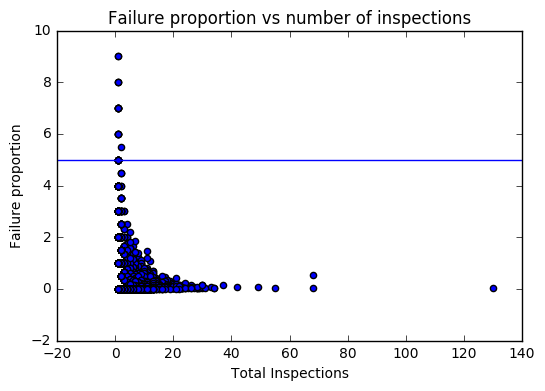

In [20]:
#df_inspection_counts
plt.scatter(df_inspection_counts["total_inspections"], df_inspection_counts["prop"] )
plt.axhline(5, label="Mean")
plt.xlabel("Total Inspections")
plt.ylabel("Failure proportion")
plt.title("Failure proportion vs number of inspections")

This is interesting... The more times an establishment is inspected, the smaller the failure proportion. That could mean a lot of things... does it mean they get better over time? You'd think that the more complaints, the more inspections, and the more failures...

In [21]:
rest[["Results", "License #"]].groupby("License #").count().head(5)

,Results
License #,
0.0,68
2.0,10
9.0,9
40.0,12
62.0,11


## Inspection Frequency

In [22]:
for a in rest["Inspection Date"].unique():
    if len(a) != 10:
        print a

11/3/16
11/2/16
11/1/16
10/18/16
10/28/16
10/31/16
10/27/16
10/26/16
10/25/16
10/24/16
10/21/16
10/20/16
10/17/16
10/14/16
10/19/16
9/20/16
10/13/16
10/11/16
10/12/16
10/7/16
10/4/16
10/6/16
9/30/16
9/13/16
9/16/16
10/5/16
9/23/16
10/3/16
9/29/16
9/28/16
9/27/16
9/26/16
9/22/16
8/8/16
7/25/16
7/13/16
8/30/16
9/21/16
7/29/16
12/29/15
7/5/16
9/19/16
9/15/16
8/2/16
9/14/16
9/9/16
9/1/16
9/8/16
6/23/16
9/12/16
6/15/16
6/13/16
9/7/16
4/7/16
8/31/16
9/6/16
9/2/16
8/29/16
3/3/16
8/23/16
2/25/16
8/22/16
8/18/16
8/5/16
8/12/16
8/26/16
6/2/16
5/12/16
8/24/16
10/23/15
11/24/15
8/10/16
8/19/16
11/9/15
8/11/16
3/8/16
4/28/16
8/17/16
8/16/16
8/15/16
8/4/16
9/2/15
7/28/16
10/1/15
1/26/16
8/9/16
1/14/16
7/27/16
8/3/16
9/23/15
12/3/15
8/1/16
7/16/15
7/26/16
7/13/15
7/15/15
6/25/15
7/19/16
7/8/16
5/4/16
7/22/16
7/15/16
7/21/16
7/7/16
12/24/15
7/20/16
6/30/16
10/6/15
7/18/16
6/21/16
7/14/16
2/19/16
2/18/16
9/22/15
6/17/16
7/12/16
5/28/15
5/11/15
7/11/16
5/20/16
7/6/16
5/25/16
4/23/15
4/28/15
4/24/15
7/1/

In [23]:
#avg # inspections per year
rest["inspection_dt"] = pd.to_datetime(rest["Inspection Date"])
rest.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude,Y,inspection_dt
1,1970772,STARBUCKS COFFEE #2827,STARBUCKS COFFEE #2827,2093906.0,Restaurant,Risk 2 (Medium),1174 E 55TH ST,60615.0,11/3/16,Canvass,Pass,41.795175,-87.596601,0.0,2016-11-03
3,1955335,CHIPOTLE MEXICAN GRILL#2768,CHIPOTLE,2476569.0,Restaurant,Risk 1 (High),806 W 63RD ST,60621.0,11/2/16,License Re-Inspection,Pass,41.779856,-87.645142,0.0,2016-11-02
4,1955334,CHIPOTLE MEXICAN GRILL#2768,CHIPOTLE,2476568.0,Restaurant,Risk 1 (High),806 W 63RD ST,60621.0,11/2/16,License Re-Inspection,Pass,41.779856,-87.645142,0.0,2016-11-02
5,1970747,SUBWAY #4267,SUBWAY,2354431.0,Restaurant,Risk 1 (High),115 E 51ST ST,60615.0,11/2/16,Canvass,Pass w/ Conditions,41.801902,-87.621926,0.0,2016-11-02
6,1970728,SANTULLO'S EATERY,SANTULLO'S EATERY,1767714.0,Restaurant,Risk 1 (High),1943-1945 W NORTH AVE,60622.0,11/2/16,Complaint,Fail,41.910387,-87.676831,1.0,2016-11-02


In [24]:
dt_grp = rest[["Results", "License #"]].groupby(["License #", rest["inspection_dt"].dt.year]).count()
dt_grp.head()

Results
License # inspection_dt         
0.0       2010                 5
          2011                 8
          2012                20
          2013                 8
          2014                 9

In [25]:
temp = dt_grp["Results"].reset_index()
temp[temp.inspection_dt == 2016]["Results"].mean()

1.4967281380130875

## Repeat Offenders

The average number inspections per license. This might be interesting to consider how a particular establishment compares to the mean, and their failure rate.

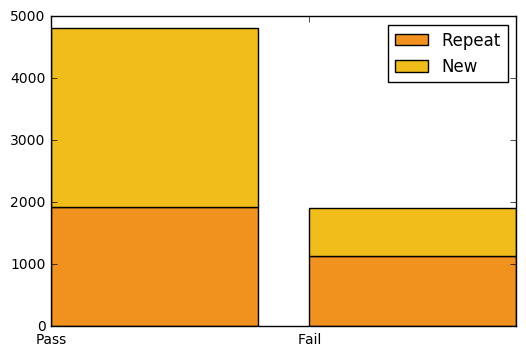

In [26]:
#previous failure have any bearing on next? show prop of failures with a previous one
#let's take only 2016 and see if any failure in the past
#we'll recode 2016 and past.. and see if there's any correlation between them
#let's calculate P(Y=1|Y_past=1) vs P(Y=1)
previous_fails = pd.DataFrame()
this_year = rest[rest["inspection_dt"].dt.year == 2016]
previous_years = rest[rest["inspection_dt"].dt.year < 2016]
temp = this_year[["License #", "Y"]].groupby("License #").max()

previous_fails = temp
previous_fails = previous_fails.reset_index("License #")

temp = previous_years[["License #", "Y"]].groupby("License #").max()
previous_fails["previous_F"] = temp.reset_index()["Y"]

#let's do some calculations and plotting:

#plt.hist(previous_fails[previous_fails["Y"] == previous_fails["previous_F"]]["Y"])
repeat_fail = previous_fails[(previous_fails["Y"] == 1) & (previous_fails["previous_F"] == 1)]["Y"].count()
new_fail = previous_fails[(previous_fails["Y"] == 1) & (previous_fails["previous_F"] == 0)]["Y"].count()
repeat_pass = previous_fails[(previous_fails["Y"] == 0) & (previous_fails["previous_F"] == 0)]["Y"].count()
new_pass = previous_fails[(previous_fails["Y"] == 0) & (previous_fails["previous_F"] == 1)]["Y"].count()
repeats = [repeat_fail, repeat_pass]
plt.bar([1,0],[repeat_fail, repeat_pass], label="Repeat", color='#F1911E')
plt.bar([1,0], [new_fail, new_pass], bottom=[repeat_fail, repeat_pass], label="New", color='#F1BD1A')
plt.xticks([1,0], ("Fail", "Pass"))

plt.legend(loc="best")

This is a bar plot of the repeat vs new pass/fail. The dark color is the repeat passers (good businesses) and failures (repeat offenders). the lighter color are first time passers and first time offenders.

In [28]:
#risk?
failures_by_risk = rest[["Results", "Risk"]].groupby("Risk").count()
failures_by_risk[failures_by_risk["Risk"]]

In [29]:
#overall probability of failing:
rest[rest["Y"] == 1].shape[0]/float(rest.shape[0])

0.20896865533543735

## Risk Score

In [30]:
#how do the risk categories compare?
failures = rest[rest["Y"] == 1]

print "P(Risk=1|Y=1) = %4f" % (failures[failures["Risk"] == "Risk 1 (High)"].shape[0]/float(failures.shape[0]))
print "P(Risk=1) = %4f" % (rest[rest["Risk"] == "Risk 1 (High)"].shape[0]/float(rest.shape[0]))
print "# of Risk 1 passing = %4f" % (rest[(rest["Risk"] == "Risk 1 (High)") & (rest["Y"] == 0)].shape[0])

print "P(Risk=2|Y=1) = %4f" % (failures[failures["Risk"] == "Risk 2 (Medium)"].shape[0]/float(failures.shape[0]))
print "P(Risk=2) = %4f" % (rest[rest["Risk"] == "Risk 2 (Medium)"].shape[0]/float(rest.shape[0]))
print "# of Risk 2 passing = %4f" % (rest[(rest["Risk"] == "Risk 2 (Medium)") & (rest["Y"] == 0)].shape[0])

print "P(Risk=3|Y=1) = %4f" % (failures[failures["Risk"] == "Risk 3 (Low)"].shape[0]/float(failures.shape[0]))
print "P(Risk=3) = %4f" % (rest[rest["Risk"] == "Risk 3 (Low)"].shape[0]/float(rest.shape[0]))
print "# of Risk 4 passing = %4f" % (rest[(rest["Risk"] == "Risk 3 (Low)") & (rest["Y"] == 0)].shape[0])

P(Risk=1|Y=1) = 0.799418
P(Risk=1) = 0.792273
# of Risk 1 passing = 49328.000000
P(Risk=2|Y=1) = 0.187117
P(Risk=2) = 0.197435
# of Risk 2 passing = 12492.000000
P(Risk=3|Y=1) = 0.013223
P(Risk=3) = 0.010241
# of Risk 4 passing = 590.000000


Risk is interesting. Are they assessed this after inspection, or by the license type before hand? In any case, Failure seems to strongly follow risk for whatever reason.

## Failures by month

In [31]:
failures = rest[rest["Y"] == 1]
month_fail_grp = failures[["Results"]].groupby(failures["inspection_dt"].dt.month).count()
month_fail_grp = month_fail_grp.reset_index()

month_all_grp = rest[["Results"]].groupby(rest["inspection_dt"].dt.month).count()
month_all_grp = month_all_grp.reset_index()

df_by_month = pd.DataFrame()
df_by_month["failures"] = month_fail_grp["Results"]
df_by_month["total"] = month_all_grp["Results"]
df_by_month["fail_prop"] = df_by_month["failures"]/df_by_month["total"]

df_by_month

,failures,total,fail_prop
0,1233,6288,0.196088
1,1246,6078,0.205002
2,1397,7201,0.194001
3,1417,6903,0.205273
4,1496,7216,0.207317
5,1594,7432,0.214478
6,1449,6494,0.223129
7,1669,7487,0.222920
8,1651,7132,0.231492
9,1417,6806,0.208199


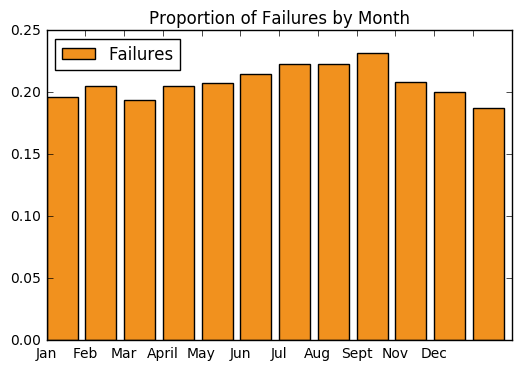

In [32]:
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11],df_by_month["fail_prop"], label="Failures", color='#F1911E')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], ("Jan", "Feb", "Mar", "April", "May", "Jun", "Jul", "Aug", "Sept", "Nov", "Dec"))
plt.legend(loc="best")
plt.title("Proportion of Failures by Month")

In [33]:
failures = rest[rest["Y"] == 1]
day_fail_grp = failures[["Results"]].groupby(failures["inspection_dt"].dt.weekday).count()
day_fail_grp = day_fail_grp.reset_index()

day_all_grp = rest[["Results"]].groupby(rest["inspection_dt"].dt.weekday).count()
day_all_grp = day_all_grp.reset_index()

df_by_day = pd.DataFrame()
df_by_day["failures"] = day_fail_grp["Results"]
df_by_day["total"] = day_all_grp["Results"]
df_by_day["fail_prop"] = df_by_day["failures"]/df_by_day["total"]

df_by_day

,failures,total,fail_prop
0,2872,13243,0.216869
1,3907,17821,0.219236
2,2832,14333,0.197586
3,3849,18205,0.211425
4,3019,15265,0.197773
5,8,26,0.307692


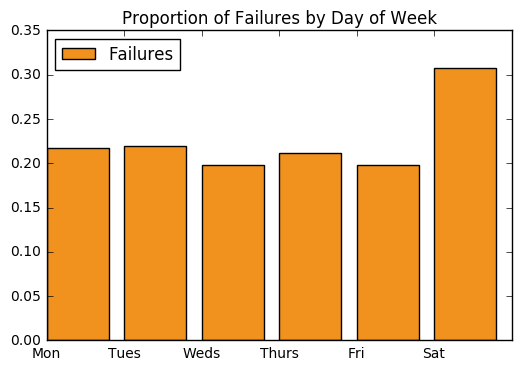

In [35]:
plt.bar([0,1,2,3,4,5],df_by_day["fail_prop"], label="Failures", color='#F1911E')
plt.xticks([0,1,2,3,4,5], ("Mon", "Tues", "Weds", "Thurs", "Fri", "Sat"))
plt.legend(loc="best")
plt.title("Proportion of Failures by Day of Week")

# Actual Cleanup Starts Here

In [180]:
#let's take the last year
#aggregate per license for past inspections
#do we want distinct inspections or licenses?
df = pd.read_csv('Food_Inspections.csv')
df.head(1)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,1970782,"MARINO'S DISTRIBUTION , INC.",MARINO'S DISTRIBUTION,2495906.0,Grocery Store,Risk 3 (Low),3939 S KEDZIE AVE,CHICAGO,IL,60632.0,11/03/2016,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.821458,-87.70435,"(41.82145816352694, -87.70435016027005)"


In [181]:
df.Results.unique()

array(['Pass', 'Pass w/ Conditions', 'Fail', 'No Entry', 'Not Ready',
       'Out of Business', 'Business Not Located'], dtype=object)

In [182]:
#Clean up our classes
#let's set up some classes... 0=fail, 1=pass, 2=pass with conditions
df.loc[df.Results == 'Fail', 'Y'] = 0
df.loc[df.Results == 'Pass', 'Y'] = 1
df.loc[df.Results == 'Pass w/ Conditions', 'Y'] = 2

#remove the other results rows
df = df[(df.Results == 'Pass') | (df.Results == 'Fail') | (df.Results == 'Pass w/ Conditions')]


In [183]:
df.loc[df.Results == 'Fail', 'Y_fail'] = 1
df.loc[df.Results != 'Fail', 'Y_fail'] = 0

In [184]:
#drop columns we don't care about
df = df.drop('Location', 1) #just a dupe of Latitude/longitude
df = df.drop('State', 1) #they're all chicago
df = df.drop('City', 1)
df = df.drop('Inspection ID', 1) #since we're going to aggregate anyway
df = df.drop('DBA Name', 1) #this is in the licenses anyway
df = df.drop('AKA Name', 1) #this is in the licenses anyway
df = df.drop('Address', 1) #this is in the licenses anyway
df = df.drop('Facility Type', 1) #this is in the licenses anyway, and is hand entered here... so very bad data

df.head(1)

,License #,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Y,Y_fail
0,2495906.0,Risk 3 (Low),60632.0,11/03/2016,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.821458,-87.70435,1.0,0.0


In [185]:
df["License #"].unique().shape[0]
#this is bigger than unique businesses, so they have multiple licenses... too bad I don't know the type...

26524

In [186]:
df.shape[0]

118520

In [187]:
df_lic = df.copy()

## Recoding the Facility Type and Inspection Type

In [188]:
#let's recode facility type and inspection type
df_lic["Inspection Type"].unique()

array(['License', 'Canvass', 'License Re-Inspection', 'Complaint',
       'Complaint Re-Inspection', 'Canvass Re-Inspection',
       'Short Form Complaint', 'Recent Inspection',
       'Suspected Food Poisoning Re-inspection',
       'Suspected Food Poisoning', 'Tag Removal', 'Consultation',
       'Special Events (Festivals)', nan, 'Complaint-Fire Re-inspection',
       'Complaint-Fire', 'Short Form Fire-Complaint', 'Non-Inspection',
       'License-Task Force', 'CORRECTIVE ACTION',
       'OWNER SUSPENDED OPERATION/LICENSE', 'LICENSE CONSULTATION',
       'License consultation', 'Task Force Liquor 1475',
       'Illegal Operation', 'fire complaint', 'Package Liquor 1474',
       'Not Ready', 'TWO PEOPLE ATE AND GOT SICK.',
       'Pre-License Consultation', 'CANVASS SPECIAL EVENTS',
       'CANVASS SCHOOL/SPECIAL EVENT', 'No entry', 'NO ENTRY',
       'TASK FORCE LIQUOR 1470', 'no entry', 'Out of Business',
       'Sample Collection', 'license task 1474', 'FIRE/COMPLAIN',
       'Tas

In [189]:
def clean_column_values(data, column, values, set_to):
    for v in values:
        data.loc[data[column] == v, column] = set_to
        

This regroups to fix typos and similarly named items.

In [190]:
#'Complaint', 'finish complaint inspection from 5-18-10'
clean_column_values(df_lic, "Inspection Type", ['Complaint', 'finish complaint inspection from 5-18-10'], 'Complaint')

#'CANVASS/SPECIAL EVENT', 'CANVASS SPECIAL EVENTS'
clean_column_values(df_lic, "Inspection Type", ['CANVASS/SPECIAL EVENT', 'CANVASS FOR RIB FEST', 'CANVASS SPECIAL EVENTS'], 'CANVASS SPECIAL EVENTS')

#'LIQUOR CATERING', 'Task Force Liquor Catering'
clean_column_values(df_lic, "Inspection Type", ['LIQUOR CATERING', 'Task Force Liquor Catering'], 'Task Force Liquor Catering')

#'CANVASS SPECIAL EVENTS', 'CANVASS SCHOOL/SPECIAL EVENT'
clean_column_values(df_lic, "Inspection Type", ['CANVASS SPECIAL EVENTS', 'CANVASS SCHOOL/SPECIAL EVENT'], 'CANVASS SPECIAL EVENTS')

#'license', 'License'
clean_column_values(df_lic, "Inspection Type", ['license', 'License'], 'License')

#'CLOSE-UP/COMPLAINT REINSPECTION', 'REINSPECTION OF CLOSE-UP'
clean_column_values(df_lic, "Inspection Type", ['CLOSE-UP/COMPLAINT REINSPECTION', 'REINSPECTION OF CLOSE-UP'], 'REINSPECTION OF CLOSE-UP')

#'1315 license reinspection', 'License Re-Inspection'
clean_column_values(df_lic, "Inspection Type", ['1315 license reinspection', 'License Re-Inspection'], 'License Reinspection')
     
#'TASK FORCE LIQUOR 1470', 'Task Force 1470 Liquor Tavern', 'TASK FORCE LIQUOR 1470'
clean_column_values(df_lic, "Inspection Type", ['TASK FORCE LIQUOR 1470', 'Task Force 1470 Liquor Tavern', 'TASK FORCE LIQUOR 1470'], 'Task Force 1470 Liquor Tavern')

#'SPECIAL TASK FORCE', 'TASKFORCE', 'task force', 'Special Task Force'
clean_column_values(df_lic, "Inspection Type", ['SPECIAL TASK FORCE', 'TASKFORCE', 'task force', 'Special Task Force'], 'Special Task Force')

#'CANVASS RE INSPECTION OF CLOSE UP', 'RE-INSPECTION OF CLOSE-UP'
clean_column_values(df_lic, "Inspection Type", ['CANVASS RE INSPECTION OF CLOSE UP', 'RE-INSPECTION OF CLOSE-UP'], 'REINSPECTION OF CLOSE-UP')

#'Business Not Located', 'POSSIBLE FBI', 'Duplicated'

#'Summer Feeding', 

#'Complaint-Fire', 'FIRE/COMPLAIN', 'fire complaint'
clean_column_values(df_lic, "Inspection Type", ['Complaint-Fire', 'FIRE/COMPLAIN', 'fire complaint'], 'Fire Complaint')

#'LICENSE TASK FORCE / NOT -FOR-PROFIT CLUB', 'LICENSE TASK FORCE / NOT -FOR-PROFIT CLU'
clean_column_values(df_lic, "Inspection Type", ['LICENSE TASK FORCE / NOT -FOR-PROFIT CLUB', 'LICENSE TASK FORCE / NOT -FOR-PROFIT CLU'], 'Task Force Not-For-Profit Club')

#"Kids Cafe'", 'KIDS CAFE'
clean_column_values(df_lic, "Inspection Type", ["Kids Cafe'", 'KIDS CAFE'], 'Kids Cafe')

#'Canvass', 'CANVAS'
clean_column_values(df_lic, "Inspection Type", ['Canvass', 'CANVAS'], 'Canvass')

#'License', 'LICENSE'
clean_column_values(df_lic, "Inspection Type", ['License', 'LICENSE'], 'License')

#'No entry', 'NO ENTRY', 'No Entry', 'no entry'
clean_column_values(df_lic, "Inspection Type", ['No entry', 'NO ENTRY', 'No Entry', 'no entry'], 'No Entry')

#'LICENSE CONSULTATION', 'License consultation'
clean_column_values(df_lic, "Inspection Type", ['LICENSE CONSULTATION', 'License consultation'], 'License Consultation')

#'LICENSE RENEWAL INSPECTION FOR DAYCARE', 'LICENSE RENEWAL FOR DAYCARE', 'DAY CARE LICENSE RENEWAL'
clean_column_values(df_lic, "Inspection Type", ['LICENSE RENEWAL INSPECTION FOR DAYCARE', 'LICENSE RENEWAL FOR DAYCARE', 'DAY CARE LICENSE RENEWAL', 'LICENSE DAYCARE 1586'], 'DAYCARE LICENSE RENEWAL')

#'TWO PEOPLE ATE AND GOT SICK.', 'Suspected Food Poisoning', 'SFP/Complaint', 'SFP', 'sfp/complaint', 'SFP/COMPLAINT'
clean_column_values(df_lic, "Inspection Type", ['TWO PEOPLE ATE AND GOT SICK.', 'Suspected Food Poisoning', 'SFP/Complaint', 'SFP', 'sfp/complaint', 'SFP/COMPLAINT'], 'Suspected Food Poisoning')

#'Suspected Food Poisoning Re-inspection', 'SFP RECENTLY INSPECTED'
clean_column_values(df_lic, "Inspection Type", ['Suspected Food Poisoning Re-inspection', 'SFP RECENTLY INSPECTED'], 'Suspected Food Poisoning Reinspection')


#'out ofbusiness', 'OUT OF BUSINESS'
clean_column_values(df_lic, "Inspection Type", ['out ofbusiness', 'OUT OF BUSINESS'], 'Out of Business')

#'Task force liquor inspection 1474', 'Task Force for liquor 1474'
clean_column_values(df_lic, "Inspection Type", ['Task force liquor inspection 1474', 'Task Force for liquor 1474','Package Liquor 1474', 'Task Force for liquor 1474', 'TASK FORCE LIQUOR 1474', 'TASK FORCE LIQUOR 1474'], 'Task Force 1474 Liquor Tavern')

#'TAVERN 1470', 'task force(1470) liquor tavern'
clean_column_values(df_lic, "Inspection Type", ['TAVERN 1470', 'task force(1470) liquor tavern'], 'Task Force 1470 Liquor Tavern')


In [191]:
df_lic[df_lic["Inspection Type"] == 'RECALL INSPECTION']

,License #,Risk,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Y,Y_fail
128820,1272529.0,Risk 1 (High),60609.0,05/11/2010,RECALL INSPECTION,Fail,NaN,41.809669,-87.675116,0.0,1.0


In [192]:
def set_qual_based_on_col(data, column_read, column_write, values):
    df_lic[column_write] = 0
    for v in values:
        data.loc[data[column_read] == v, column_write] = 1

Correcting Inspection Type for typos

In [193]:


set_qual_based_on_col(df_lic, 'Inspection Type', 'reinspection?', ['Complaint Re-Inspection', 'Canvass Re-Inspection', 'Complaint-Fire Re-inspection', 'RECALL INSPECTION',
       'REINSPECTION OF 48 HOUR NOTICE', 'REINSPECTION','REINSPECTION OF CLOSE-UP', 'Suspected Food Poisoning Reinspection','License Reinspection'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'recent_inspection?', ['Recent Inspection'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'task_force?', ['License-Task Force', 'Task Force Liquor 1475',
       'Task Force 1474 Liquor Tavern','Task Force 1470 Liquor Tavern', 'license task 1474', 
       'Task Force Liquor Catering', 'TASK FORCE NIGHT','Special Task Force',
       'Task Force Not-For-Profit Club','TASK FORCE PACKAGE LIQUOR','TASK FORCE LIQUOR (1481)','LIQOUR TASK FORCE NOT READY', 'TASK FORCE NOT READY',
       'TASK FORCE PACKAGE GOODS 1474'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'special_event?', ['Special Events (Festivals)','CANVASS SPECIAL EVENTS', 'Summer Feeding', 'TASTE OF CHICAGO'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'canvass?', ['Canvass','Canvass Re-Inspection', 'CANVASS SPECIAL EVENTS'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'closeup?', ['RE-INSPECTION OF CLOSE-UP','RE-INSPECTION OF CLOSE-UP'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'liquor?', ['Task Force Liquor 1475','Task Force 1474 Liquor Tavern',
      'Task Force 1470 Liquor Tavern','Task Force Liquor Catering','TASK FORCE PACKAGE LIQUOR','TASK FORCE LIQUOR (1481)'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'fire?', ['Complaint-Fire Re-inspection', 'Fire Complaint',
       'Short Form Fire-Complaint'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'child?', ['Kids Cafe', 'DAYCARE LICENSE RENEWAL'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'no_entry?', ['No Entry','NO ENTRY-SHORT COMPLAINT)'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'complaint?', ['Complaint',
       'Complaint Re-Inspection', 'Short Form Complaint','Complaint-Fire Re-inspection', 'Fire Complaint',
       'Short Form Fire-Complaint','SMOKING COMPLAINT','NO ENTRY-SHORT COMPLAINT)'])

set_qual_based_on_col(df_lic, 'Inspection Type', 'license?', ['License', 'License Reinspection','License-Task Force',
       'OWNER SUSPENDED OPERATION/LICENSE','License Consultation','Pre-License Consultation','license task 1474',
       'DAYCARE LICENSE RENEWAL','LICENSE/NOT READY','LICENSE WRONG ADDRESS', 'LICENSE REQUEST'])

In [194]:
#recode Inspection Type
#df_lic["inspection_type"] = df_lic["Inspection Type"].astype('category')
#df_lic = df_lic.drop('Inspection Type', 1)

Renaming the cleaned columns

In [195]:
df_lic.rename(columns={"Risk": "risk_description", "Results": "Y_description", "Inspection Date": "inspection_date_string"}, inplace=True)

In [196]:
df_lic.head(1)

,License #,risk_description,Zip,inspection_date_string,Inspection Type,Y_description,Violations,Latitude,Longitude,Y,...,task_force?,special_event?,canvass?,closeup?,liquor?,fire?,child?,no_entry?,complaint?,license?
0,2495906.0,Risk 3 (Low),60632.0,11/03/2016,License,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.821458,-87.70435,1.0,...,0,0,0,0,0,0,0,0,0,1


## Encoding Risk

In [197]:
#encode fix risk
df_lic["risk"] = 0
df_lic.loc[df_lic["risk_description"] == 'Risk 1 (High)', "risk"] = 1
df_lic.loc[df_lic["risk_description"] == 'Risk 2 (Medium)', "risk"] = 2
df_lic.loc[df_lic["risk_description"] == 'Risk 3 (Low)', "risk"] = 3


#encode inspection type
inspection_types = df_lic["Inspection Type"].unique()
for i,item in enumerate(inspection_types):
    df_lic.loc[df_lic["Inspection Type"] == item, 'inspection_type'] = i

## Removing empty licenses and duplicate inspections

In [198]:
df_lic = df_lic[df_lic["License #"] != 0]
df_lic = df_lic[df_lic["Inspection Type"] != 'Duplicated']
df_lic = df_lic.drop('Inspection Type', 1)

## Encoding inspection date as a date

In [199]:
#aggregate past years: previous fail, ever fail, mean inspection rate (per year)
df_lic["inspection_dt"] = pd.to_datetime(df_lic["inspection_date_string"])

In [200]:
df_lic[df_lic["inspection_dt"].dt.year < 2015].shape


(86397, 25)

In [201]:
df_lic["inspection_dt"].dt.year.unique()

array([2016, 2015, 2014, 2013, 2012, 2011, 2010])

## Encoding "Did you pass last time?"

In [202]:
df_lic["prev_fail"] = 0

for y in range(2011, 2017):
    last2_inspections = df_lic[df_lic["inspection_dt"].dt.year <= y].sort("inspection_dt", ascending=False).groupby("License #").head(2)
    last_inspection = df_lic[df_lic["inspection_dt"].dt.year <= y].sort("inspection_dt", ascending=False).groupby("License #").head(1)

    #remove the last_inspection from the last 2... what's left is the one before this one
    inspection_before_last = last2_inspections[~last2_inspections.isin(last_inspection)]

    #Note: there's another way to do this... use duplicated, take last.. but this works
    
    #because of the grouping, the previous operation coded the first inspections as NaN.. we need to remove those
    inspection_before_last = inspection_before_last[~inspection_before_last["License #"].isnull()]

    #now, let's see the previous outcome and create a column called "prev_fail"
    inspection_before_last_fails = inspection_before_last[inspection_before_last["Y_fail"] == 1]
    last_inspection.loc[last_inspection["License #"].isin(inspection_before_last_fails["License #"]), "prev_fail"] = 1
    last_inspection_fails = last_inspection[last_inspection["prev_fail"] == 1]

    results = df_lic[~df_lic[df_lic.isin(last_inspection_fails)].isnull()]
    results = results[~results["License #"].isnull()]

    df_lic.loc[df_lic[~df_lic[df_lic.isin(results)]["License #"].isnull()].index, "prev_fail"] = 1

/Users/angelo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/angelo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [203]:
#sanity check... shouldn't have NaNs
df_lic.prev_fail.unique()

array([0, 1])

## Encoding "Cumulative Failures"

In [204]:
df_lic["cumulative_failures"] = 0

for y in range(2011, 2017):
    last_inspection = df_lic[df_lic["inspection_dt"].dt.year <= y].sort("inspection_dt", ascending=False).groupby("License #").head(1)
    prior_failed_inspections = df_lic[(df_lic["inspection_dt"].dt.year <= y) & (df_lic["Y_fail"]==1)]

    pre_count = prior_failed_inspections[["License #", "Y_fail"]]
    fail_counts = pre_count.groupby("License #").count()
    fail_counts = fail_counts.reset_index()
    #I don't need the index since I'm going to use this as a lookup... but, I don't want a multiindex

    results = df_lic[~df_lic[df_lic.isin(last_inspection_fails)].isnull()]
    results = results[~results["License #"].isnull()]

    def set_count(row):
        if fail_counts[fail_counts["License #"] == row["License #"]]["Y_fail"].any() == True:
            c = fail_counts[fail_counts["License #"] == row["License #"]]["Y_fail"]
            #note: the index in a row is "name"
            df_lic.set_value(row.name, "cumulative_failures", c)

    df_lic[~df_lic[df_lic.isin(results)]["License #"].isnull()].apply(lambda row: set_count(row), axis=1)


/Users/angelo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [205]:
#sanity check.. they applied
df_lic["cumulative_failures"].unique()

array([ 0,  1,  5,  3,  2,  7,  4,  6,  8,  9, 13, 10, 11, 16])

## Encoding "Have you ever failed?"

In [206]:
df_lic["ever_failed"] = 0
df_lic.loc[df_lic["cumulative_failures"] != 0, "ever_failed"] = 1
df_lic["ever_failed"].unique()

array([0, 1])

## Encoding Cumulative Inspections

In [207]:
df_lic["cumulative_inspections"] = 0

for y in range(2011, 2017):
    last_inspection = df_lic[df_lic["inspection_dt"].dt.year <= y].sort("inspection_dt", ascending=False).groupby("License #").head(1)
    prior_inspections = df_lic[(df_lic["inspection_dt"].dt.year <= y)]

    prior_counts = prior_inspections[["License #", "Y_fail"]].groupby("License #").count()
    prior_counts = prior_counts.reset_index()
    #I don't need the index since I'm going to use this as a lookup... but, I don't want a multiindex

    results = df_lic[~df_lic[df_lic.isin(prior_inspections)].isnull()]
    results = results[~results["License #"].isnull()]

    def set_count(row):
        if prior_counts[prior_counts["License #"] == row["License #"]]["Y_fail"].any() == True:
            c = prior_counts[prior_counts["License #"] == row["License #"]]["Y_fail"]
            #note: the index in a row is "name"
            df_lic.set_value(row.name, "cumulative_inspections", c)

    df_lic[~df_lic[df_lic.isin(results)]["License #"].isnull()].apply(lambda row: set_count(row), axis=1)

/Users/angelo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [208]:
#sanity check.. they applied
df_lic["cumulative_inspections"].unique()

array([  1,   8,   2,   5,  16,   9,   3,  13,  12,  10,   6,   4,   7,
        30,  11,  23,  18,  20,  34,  15,  22,  14,  24,  19,  28,  17,
        32,  26,  37,  21,  38,  42,  25,  41,  35, 170,  29,  33,   0,
        77,  27,  56,  31, 130])

## Encoding Proportion of Fails to Inspections

In [209]:
df_lic["proportion_past_failures"] = df_lic["cumulative_failures"]/df_lic["cumulative_inspections"]
df_lic["proportion_past_failures"].unique()

array([ 0.        ,  0.5       ,  0.55555556,  0.6       ,  0.33333333,
        0.2       ,  0.4       ,  0.63636364,  0.28571429,  0.38461538,
        0.29166667,  0.36363636,  0.25      ,  0.44444444,  0.07142857,
        0.26666667,  0.125     ,  0.30769231,  0.16666667,  0.35      ,
        0.23076923,  0.13636364,  0.66666667,  0.22222222,  0.375     ,
        0.625     ,  0.18181818,  0.27272727,  0.1       ,  0.23529412,
        0.54545455,  0.11111111,  0.21428571,  0.42857143,  0.14285714,
        0.46666667,  1.        ,  0.4375    ,  0.07692308,  0.3       ,
        0.17647059,  0.35714286,  0.13333333,  0.26315789,  0.3125    ,
        0.15384615,  0.22727273,  0.31578947,  0.57142857,  0.06666667,
        0.46153846,  0.41176471,  0.27777778,  0.45454545,  0.08333333,
        0.29411765,  0.41666667,  0.0625    ,  0.35294118,  0.05882353,
        0.8       ,  0.35135135,  0.30434783,  0.42105263,  0.20833333,
        0.09090909,  0.58333333,  0.38888889,  0.32      ,  0.11

## Encoding Days Since Last Inspection

In [210]:
df_lic["days_since_last_inspection"] = np.nan

for y in range(2011, 2017):
    last2_inspections = df_lic[df_lic["inspection_dt"].dt.year <= y].sort("inspection_dt", ascending=False).groupby("License #").head(2)
    last_inspection = df_lic[df_lic["inspection_dt"].dt.year <= y].sort("inspection_dt", ascending=False).groupby("License #").head(1)

    #remove the last_inspection from the last 2... what's left is the one before this one
    inspection_before_last = last2_inspections[~last2_inspections.isin(last_inspection)]

    #copying and resetting indexes so we can compare them without iterating (they're the same if they have the same license #)
    previous_temp = inspection_before_last.copy() #inspection_before_last[inspection_before_last["License #"].isin(inspection_before_last["License #"])]
    previous_temp = previous_temp.set_index("License #")
    this_temp = last_inspection.copy()
    this_temp = this_temp.set_index("License #")

    days_since_lookup = (this_temp["inspection_dt"] - previous_temp["inspection_dt"]).apply(lambda l: l.days if pd.isnull(l) == False else np.nan)
    def set_days_since(row):
        if days_since_lookup[days_since_lookup.index == row["License #"]].any() == True:
            d = days_since_lookup[days_since_lookup.index == row["License #"]]
            #note: the index in a row is "name"
            df_lic.set_value(row.name, "days_since_last_inspection", d)


    #now, what we have to do it find the last_inspections in the main set, and drop in the new calulated field
    df_lic[~df_lic[df_lic.isin(last_inspection)]["License #"].isnull()].apply(lambda row: set_days_since(row), axis=1)

/Users/angelo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/angelo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [211]:
df_lic["days_since_last_inspection"].unique()

array([  nan,  373.,    8., ...,  843.,  877.,  866.])

## Save our results

In [212]:
df_lic.head()

,License #,risk_description,Zip,inspection_date_string,Y_description,Violations,Latitude,Longitude,Y,Y_fail,...,license?,risk,inspection_type,inspection_dt,prev_fail,cumulative_failures,ever_failed,cumulative_inspections,proportion_past_failures,days_since_last_inspection
0,2495906.0,Risk 3 (Low),60632.0,11/03/2016,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.821458,-87.704350,1.0,0.0,...,1,3,0.0,2016-11-03,0,0,0,1,0.0,NaN
1,2093906.0,Risk 2 (Medium),60615.0,11/03/2016,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.795175,-87.596601,1.0,0.0,...,0,2,1.0,2016-11-03,0,0,0,8,0.0,373.0
2,2495782.0,Risk 3 (Low),60628.0,11/03/2016,Pass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.714126,-87.642853,1.0,0.0,...,1,3,0.0,2016-11-03,0,0,0,1,0.0,NaN
3,2476569.0,Risk 1 (High),60621.0,11/02/2016,Pass,NaN,41.779856,-87.645142,1.0,0.0,...,1,1,2.0,2016-11-02,1,1,1,2,0.5,8.0
4,2476568.0,Risk 1 (High),60621.0,11/02/2016,Pass,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.779856,-87.645142,1.0,0.0,...,1,1,2.0,2016-11-02,1,1,1,2,0.5,8.0


In [213]:
#drop the violations to make the set reasonable in size... it's 90% of the file size
df_lic = df_lic.drop("Violations", 1)

In [214]:
df_lic.to_csv('inspections_clean.csv')

## Inspection Type, Risk, Result, Inspection Date are kept for friendly names of the computed columns... feel free to delete
